<table width='100%' border='0'>
    <tr>
        <td><img src='../C:/Users/souka/Downloads/s1.jfif' width='150' height='150'></td>
        <td style="text-align:center;">
            <h3>Université Chouaib Doukkali</h3>
            <h3>Faculté des Sciences – El Jadida</h3>
        </td>
        <td style="text-align:right; padding-right: 1em;"><img src='../C:/Users/souka/Downloads/s2.jfif' width='120'></td>
    </tr>
</table>


</html>


## Installation des packages nécessaires

In [89]:
pip install requests pandas numpy matplotlib

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


DEPRECATION: Loading egg at c:\programdata\anaconda3\lib\site-packages\vboxapi-1.0-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330


## Récupération et nettoyage des données de l'API Scopus

In [1]:
import requests
import pandas as pd

def fetch_scopus_data(api_key, query, count=25):
    """Fetch data from the Scopus API."""
    url = 'https://api.elsevier.com/content/search/scopus'
    params = {
        'apiKey': api_key,
        'query': query,
        'count': count
    }
    
    try:
        # Effectuer la requête GET à l'API Scopus
        response = requests.get(url, params=params)
        response.raise_for_status()  # Vérifier s'il y a eu une erreur dans la requête
        
        # Convertir la réponse JSON en dictionnaire
        data = response.json()
        
        # Vérifier si les données attendues sont présentes dans la réponse
        if 'search-results' in data and 'entry' in data['search-results']:
            print("La clé API est valide et fonctionne correctement.")
            print(f"Nombre de résultats obtenus : {len(data['search-results']['entry'])}")
            return data['search-results']['entry']
        else:
            print("La structure de la réponse JSON ne contient pas les clés attendues.")
            return None
    
    except requests.exceptions.HTTPError as http_err:
        print(f'Erreur HTTP {response.status_code}: {response.reason}')
        print(response.text)
    except requests.exceptions.RequestException as req_err:
        print(f'Erreur de requête: {req_err}')
    except Exception as err:
        print(f'Erreur: {err}')

def parse_freetoread(value):
    """Transform the 'freetoread.value' column to readable values."""
    if isinstance(value, list):
        return ', '.join([item['$'] for item in value])
    return value

def clean_and_save_data(entries, filename):
    """Clean the data and save it to a CSV file."""
    if entries:
        # Convertir les entrées JSON en DataFrame Pandas
        df = pd.json_normalize(entries)
        
        # Nettoyer et organiser les données
        if 'freetoread.value' in df.columns:
            df['freetoread.value'] = df['freetoread.value'].apply(parse_freetoread)
        
        # Définir les options d'affichage de Pandas pour afficher toutes les lignes et colonnes
        pd.set_option('display.max_rows', None)
        pd.set_option('display.max_columns', None)
        pd.set_option('display.width', None)
        pd.set_option('display.max_colwidth', None)

        # Afficher le DataFrame nettoyé
        print(df)
        
        # Sauvegarder le DataFrame dans un fichier CSV
        df.to_csv(filename, index=False)
        print(f"Les données ont été nettoyées et sauvegardées dans le fichier {filename}")

# Utiliser les fonctions pour récupérer, nettoyer et sauvegarder les données
api_key = '9aebde1fa88b0b7325c7d8054dd3e754'
query = 'KEY(scopus)'
filename = 'api_scopus_data.csv'

entries = fetch_scopus_data(api_key, query)
clean_and_save_data(entries, filename)

La clé API est valide et fonctionne correctement.
Nombre de résultats obtenus : 25
    @_fa  \
0   true   
1   true   
2   true   
3   true   
4   true   
5   true   
6   true   
7   true   
8   true   
9   true   
10  true   
11  true   
12  true   
13  true   
14  true   
15  true   
16  true   
17  true   
18  true   
19  true   
20  true   
21  true   
22  true   
23  true   
24  true   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                link  \
0   [{'@_fa': 'true', '@ref': 'self', '@href': 'http

## Récupération et parsing des données de DOI depuis l'API Elsevier

In [2]:
import requests
import pandas as pd
import xml.etree.ElementTree as ET

# Liste de DOI à récupérer depuis l'API Elsevier
dois = [
    '10.1016/j.cplett.2020.137481',
    '10.1016/j.joule.2020.11.010',
    '10.1016/j.jacc.2020.11.012'
]

# Clé API Elsevier
api_key = '9aebde1fa88b0b7325c7d8054dd3e754'

# Fonction pour récupérer et parser les données d'un DOI spécifique depuis l'API Elsevier
def get_data_from_doi(doi):
    url = f'https://api.elsevier.com/content/article/doi/{doi}'
    headers = {'X-ELS-APIKey': api_key, 'Accept': 'application/xml'}
    
    try:
        response = requests.get(url, headers=headers)
        response.raise_for_status()
        
        print(f'Statut pour DOI {doi}: {response.status_code}')
        
        root = ET.fromstring(response.content)
        return parse_xml(root)
    
    except requests.exceptions.HTTPError as err:
        print(f'Erreur HTTP lors de la récupération du DOI {doi}: {err}')
        return None
    
    except ET.ParseError as e:
        print(f'Erreur de parsing XML pour le DOI {doi}: {e}')
        return None
    
    except Exception as err:
        print(f'Erreur lors de la récupération du DOI {doi}: {err}')
        return None

# Fonction pour parser les données XML et extraire les informations pertinentes
def parse_xml(root):
    namespaces = {
        'dtd': 'http://www.elsevier.com/xml/svapi/article/dtd',
        'dc': 'http://purl.org/dc/elements/1.1/',
        'prism': 'http://prismstandard.org/namespaces/basic/2.0/',
        'xocs': 'http://www.elsevier.com/xml/xocs/dtd'
    }

    data = {
        'doi': root.findtext('.//xocs:doi', namespaces=namespaces),
        'title': root.findtext('.//dc:title', namespaces=namespaces),
        'creator': root.findtext('.//dc:creator', namespaces=namespaces),
        'publicationName': root.findtext('.//prism:publicationName', namespaces=namespaces),
        'volume': root.findtext('.//prism:volume', namespaces=namespaces),
        'issue': root.findtext('.//prism:issueIdentifier', namespaces=namespaces),
        'pageRange': root.findtext('.//prism:pageRange', namespaces=namespaces),
        'coverDate': root.findtext('.//prism:coverDate', namespaces=namespaces),
        'citedby_count': root.findtext('.//xocs:citedby-count', namespaces=namespaces)
    }

    link_elements = root.findall('.//xocs:link', namespaces=namespaces)
    for link in link_elements:
        if link.get('rel') == 'scidir':
            data['doiLink'] = link.get('href')
            break

    return data

# Liste pour stocker les données récupérées depuis les DOI
data_list = []

try:
    # Parcourir la liste des DOI et récupérer les données pour chaque DOI
    for doi in dois:
        data = get_data_from_doi(doi)
        if data:
            data_list.append(data)

    if data_list:
        # Créer un DataFrame à partir des données récupérées
        df_xml = pd.DataFrame(data_list)

        # Convertir le DataFrame en JSON
        df_xml_json = df_xml.to_json(orient='records')

        # Afficher le JSON
        print("\nDataFrame JSON à partir des DOI de l'API Elsevier:")
        print(df_xml_json)

        # Sauvegarder le JSON dans un fichier
        with open('scopus_data_from_dois.json', 'w', encoding='utf-8') as f:
            f.write(df_xml_json)
    else:
        print("Aucune donnée valide n'a été récupérée depuis les DOI.")

except requests.exceptions.HTTPError as err:
    print(f'Erreur HTTP lors de la requête à l\'API Elsevier: {err}')
except Exception as err:
    print(f'Erreur: {err}')


Statut pour DOI 10.1016/j.cplett.2020.137481: 200
Statut pour DOI 10.1016/j.joule.2020.11.010: 200
Statut pour DOI 10.1016/j.jacc.2020.11.012: 200

DataFrame JSON à partir des DOI de l'API Elsevier:
[{"doi":"10.1016\/j.cplett.2020.137481","title":"Effect of Ni2+ ions concentration on the local crystal field of Zn1-\n               \n                  x\n               Ni\n                  x\n               Te nanocrystals ","creator":"Silva, Alessandra S.","publicationName":"Chemical Physics Letters","volume":"750","issue":null,"pageRange":"137481","coverDate":"2020-07-31","citedby_count":null},{"doi":"10.1016\/j.joule.2020.11.010","title":"Design and Manufacture of 3D-Printed Batteries ","creator":"Lyu, Zhiyang","publicationName":"Joule","volume":"5","issue":"1","pageRange":"89-114","coverDate":"2021-01-20","citedby_count":null},{"doi":"10.1016\/j.jacc.2020.11.012","title":"2021 ACC\/AHA Key Data Elements and Definitions for Heart Failure A Report of the American College of Cardiolog

## Affichage des colonnes du DataFrame


In [13]:
df.columns

Index(['@_fa', 'link', 'prism:url', 'dc:identifier', 'eid', 'dc:title',
       'dc:creator', 'prism:publicationName', 'prism:eIssn', 'prism:volume',
       'prism:issueIdentifier', 'prism:pageRange', 'prism:coverDate',
       'prism:coverDisplayDate', 'prism:doi', 'citedby-count', 'affiliation',
       'prism:aggregationType', 'subtype', 'subtypeDescription',
       'article-number', 'source-id', 'openaccess', 'openaccessFlag',
       'freetoread.value', 'freetoreadLabel.value', 'prism:issn', 'pubmed-id',
       'coverYear'],
      dtype='object')

## Affichage des premières lignes du DataFrame


In [14]:
df.head()

,@_fa,link,prism:url,dc:identifier,eid,dc:title,dc:creator,prism:publicationName,prism:eIssn,prism:volume,...,subtypeDescription,article-number,source-id,openaccess,openaccessFlag,freetoread.value,freetoreadLabel.value,prism:issn,pubmed-id,coverYear
0,True,"[{'@_fa': 'true', '@ref': 'self', '@href': 'ht...",https://api.elsevier.com/content/abstract/scop...,SCOPUS_ID:85196156602,2-s2.0-85196156602,Efficacy and safety of omega-3 fatty acids sup...,Bafkar N.,BMC Psychiatry,1471244X,24,...,Article,455,14260,1,True,"all, publisherfullgold","[{'$': 'All Open Access'}, {'$': 'Gold'}]",NaN,NaN,2024
1,True,"[{'@_fa': 'true', '@ref': 'self', '@href': 'ht...",https://api.elsevier.com/content/abstract/scop...,SCOPUS_ID:85196115487,2-s2.0-85196115487,A systematic review on the efficacy of adjunct...,Montano N.,Neurosurgical Review,14372320,47,...,Review,276,22097,0,False,NaN,NaN,03445607,38884812.0,2024
2,True,"[{'@_fa': 'true', '@ref': 'self', '@href': 'ht...",https://api.elsevier.com/content/abstract/scop...,SCOPUS_ID:85196086633,2-s2.0-85196086633,Influence of elastomeric and steel ligatures o...,Hussain U.,Progress in Orthodontics,21961042,25,...,Review,24,91796,1,True,"all, publisherfullgold","[{'$': 'All Open Access'}, {'$': 'Gold'}]",17237785,38880839.0,2024
3,True,"[{'@_fa': 'true', '@ref': 'self', '@href': 'ht...",https://api.elsevier.com/content/abstract/scop...,SCOPUS_ID:85195598662,2-s2.0-85195598662,Effect of zinc supplementation on glycemic bio...,Daneshvar M.,Diabetology and Metabolic Syndrome,17585996,16,...,Review,124,19700174930,1,True,"all, publisherfullgold","[{'$': 'All Open Access'}, {'$': 'Gold'}]",NaN,NaN,2024
4,True,"[{'@_fa': 'true', '@ref': 'self', '@href': 'ht...",https://api.elsevier.com/content/abstract/scop...,SCOPUS_ID:85195533502,2-s2.0-85195533502,Barriers and facilitators to implementing work...,Paterson C.,Systematic Reviews,20464053,13,...,Article,152,21100237425,1,True,"all, publisherfullgold","[{'$': 'All Open Access'}, {'$': 'Gold'}]",NaN,38849924.0,2024


## Informations sur le DataFrame


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25 entries, 0 to 24
Data columns (total 29 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   @_fa                    25 non-null     bool   
 1   link                    25 non-null     object 
 2   prism:url               25 non-null     object 
 3   dc:identifier           25 non-null     object 
 4   eid                     25 non-null     object 
 5   dc:title                25 non-null     object 
 6   dc:creator              25 non-null     object 
 7   prism:publicationName   25 non-null     object 
 8   prism:eIssn             25 non-null     object 
 9   prism:volume            25 non-null     int64  
 10  prism:issueIdentifier   25 non-null     int64  
 11  prism:pageRange         0 non-null      float64
 12  prism:coverDate         25 non-null     object 
 13  prism:coverDisplayDate  25 non-null     object 
 14  prism:doi               25 non-null     obje

## Analyse des données de citations par année

In [92]:
import pandas as pd
import matplotlib.pyplot as plt

def analyze_data(df):
    """Analyze the data and provide insights."""
    if df is not None:
        # Calculer le nombre total de citations
        if 'citedby-count' in df.columns:
            df['citedby-count'] = pd.to_numeric(df['citedby-count'], errors='coerce').fillna(0).astype(int)
            total_citations = df['citedby-count'].sum()
            print(f"\nNombre total de citations pour toutes les publications: {total_citations}")
        
        # Répartition des citations par année de publication
        if 'prism:coverDate' in df.columns:
            df['coverYear'] = pd.to_datetime(df['prism:coverDate'], errors='coerce').dt.year
            citations_per_year = df.groupby('coverYear')['citedby-count'].sum()
            
            # Affichage des citations par année de publication détaillé
            print("\nCitations par année de publication :")
            for year, citations in citations_per_year.items():
                print(f"Année {year} : {citations} citations")

# Charger le DataFrame sauvegardé depuis le fichier CSV
df = pd.read_csv('api_scopus_data.csv')

# Analyser les données
analyze_data(df)



Nombre total de citations pour toutes les publications: 17

Citations par année de publication :
Année 2024 : 17 citations
Année 2025 : 0 citations


## Calcul du nombre total de publications dans le dataset

In [93]:
def total_publications(df):
    """Calculates the total number of publications."""
    if df is not None:
        total = len(df)
        print(f"\nNombre total de publications dans le dataset : {total}")
    else:
        print("Aucune donnée à analyser.")

# Appel de la fonction
total_publications(df)



Nombre total de publications dans le dataset : 25


## Calcul du nombre total de citations pour toutes les publications


In [94]:
def total_citations(df):
    """Calculates the total number of citations."""
    if 'citedby-count' in df.columns:
        total_citations = df['citedby-count'].sum()
        print(f"\nNombre total de citations pour toutes les publications : {total_citations}")
    else:
        print("La colonne 'citedby-count' n'est pas présente dans le DataFrame.")

# Appel de la fonction
total_citations(df)



Nombre total de citations pour toutes les publications : 17


## Calcul de la moyenne des citations par publication


In [95]:
def average_citations(df):
    """Calculates the average citations per publication."""
    if 'citedby-count' in df.columns:
        average_citations = df['citedby-count'].mean()
        print(f"\nCitations moyennes par publication : {average_citations:.2f}")
    else:
        print("La colonne 'citedby-count' n'est pas présente dans le DataFrame.")

# Appel de la fonction
average_citations(df)



Citations moyennes par publication : 0.68


## Identification des publications avec le plus de citations


In [96]:
def publications_most_citations(df, top_n=5):
    """Identifie les publications avec le plus de citations."""
    if 'citedby-count' in df.columns:
        top_publications = df.nlargest(top_n, 'citedby-count')[['dc:title', 'citedby-count']]
        print(f"\nPublications avec le plus de citations (Top {top_n}) :")
        print(top_publications)
    else:
        print("La colonne 'citedby-count' n'est pas présente dans le DataFrame.")

# Charger le DataFrame sauvegardé depuis le fichier CSV
df = pd.read_csv('api_scopus_data.csv')

# Appel de la fonction
publications_most_citations(df)



Publications avec le plus de citations (Top 5) :
                                                                                                                                                                                          dc:title  \
16                                                                                    Beyond playing 20 questions with nature: Integrative experiment design in the social and behavioral sciences   
20                                                                                                                            A practical guide to adopting Bayesian analyses in clinical research   
0                                                                                                           Influence of phytoplankton, bacteria and viruses on nutrient supply in tropical waters   
1   Safety and efficacy of low-power pure-cut hot snare polypectomy for small nonpedunculated colorectal polyps compared with conventional resection methods: 

## Calcul de la corrélation entre le nombre de citations et les années de publication

In [99]:
def correlation_citations_annees(df):
    """Calcule la corrélation entre le nombre de citations et les années de publication."""
    if 'citedby-count' in df.columns and ('prism:coverDate' in df.columns or 'prism:coverDisplayDate' in df.columns):
        if 'prism:coverDate' in df.columns:
            df['coverYear'] = pd.to_datetime(df['prism:coverDate'], errors='coerce').dt.year
        elif 'prism:coverDisplayDate' in df.columns:
            df['coverYear'] = pd.to_datetime(df['prism:coverDisplayDate'], errors='coerce').dt.year
        
        correlation = df[['coverYear', 'citedby-count']].corr().iloc[0, 1]
        print(f"\nCorrélation entre le nombre de citations et les années de publication : {correlation:.2f}")
    else:
        print("Les colonnes nécessaires ('citedby-count' et 'prism:coverDate' ou 'prism:coverDisplayDate') ne sont pas présentes dans le DataFrame.")

# Appel de la fonction pour calculer la corrélation entre le nombre de citations et les années de publication
correlation_citations_annees(df)



Corrélation entre le nombre de citations et les années de publication : -0.24


## Analyse de la répartition des publications en accès libre

In [101]:
def publications_acces_libre(df):
    """Analyse la répartition des publications en accès libre."""
    if 'openaccessFlag' in df.columns:
        publications_open_access = df['openaccessFlag'].value_counts()
        print("\nRépartition des publications par statut d'accès libre :")
        print(publications_open_access)
    else:
        print("La colonne 'openaccessFlag' n'est pas présente dans le DataFrame.")

# Appel de la fonction pour analyser la répartition des publications en accès libre
publications_acces_libre(df)



Répartition des publications par statut d'accès libre :
openaccessFlag
True     19
False     6
Name: count, dtype: int64


## Analyse de la répartition des publications par année

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

def analyze_data(df):
    """Analyze the data and provide insights."""
    if df is not None:
        # Ajouter une colonne pour l'année de publication
        if 'prism:coverDate' in df.columns:
            df['coverYear'] = pd.to_datetime(df['prism:coverDate'], errors='coerce').dt.year

        # Répartition des publications par année
        if 'coverYear' in df.columns:
            publications_per_year = df.groupby('coverYear')['dc:title'].count().reset_index(name='Publications')
            print("\nRépartition des publications par année :")
            print(publications_per_year)

# Charger le DataFrame sauvegardé depuis le fichier CSV
df = pd.read_csv('api_scopus_data.csv')

# Analyser les données
analyze_data(df)



Répartition des publications par année :
   coverYear  Publications
0       2024            25


## Analyse de la répartition des publications par source


In [102]:
def publications_par_source(df):
    """Analyse la répartition des publications par source."""
    if 'prism:publicationName' in df.columns:
        publications_by_source = df['prism:publicationName'].value_counts().head(10)
        print("\nRépartition des publications par source (Top 10) :")
        print(publications_by_source)
    else:
        print("La colonne 'prism:publicationName' n'est pas présente dans le DataFrame.")

# Appel de la fonction pour analyser la répartition des publications par source
publications_par_source(df)



Répartition des publications par source (Top 10) :
prism:publicationName
Journal of Advanced Research in Applied Sciences and Engineering Technology    3
Dados                                                                          3
International Journal of Religion and Spirituality in Society                  2
Journal of Environmental Sciences (China)                                      1
Behavioral and Brain Sciences                                                  1
Substance Abuse: Treatment, Prevention, and Policy                             1
Sports Medicine - Open                                                         1
Experimental Hematology and Oncology                                           1
Journal of Clinical and Translational Science                                  1
Chinese Journal of Tissue Engineering Research                                 1
Name: count, dtype: int64


## Analyse de la présence des identifiants PubMed dans les publications


In [103]:
def publications_pubmed_id(df):
    """Analyse la présence des identifiants PubMed dans les publications."""
    if 'pubmed-id' in df.columns:
        publications_with_pubmed_id = df['pubmed-id'].notna().sum()
        total_publications = len(df)
        print(f"\nNombre de publications avec identifiant PubMed : {publications_with_pubmed_id} sur {total_publications} publications au total.")
    else:
        print("La colonne 'pubmed-id' n'est pas présente dans le DataFrame.")

# Appel de la fonction pour analyser la présence des identifiants PubMed dans les publications
publications_pubmed_id(df)



Nombre de publications avec identifiant PubMed : 3 sur 25 publications au total.


## Analyse de la répartition des publications par type de sous-catégorie


In [104]:
def publications_par_sous_categorie(df):
    """Analyse la répartition des publications par type de sous-catégorie."""
    if 'subtypeDescription' in df.columns:
        publications_by_subtype = df['subtypeDescription'].value_counts().head(10)
        print("\nRépartition des publications par type de sous-catégorie (Top 10) :")
        print(publications_by_subtype)
    else:
        print("La colonne 'subtypeDescription' n'est pas présente dans le DataFrame.")

# Appel de la fonction pour analyser la répartition des publications par type de sous-catégorie
publications_par_sous_categorie(df)



Répartition des publications par type de sous-catégorie (Top 10) :
subtypeDescription
Article    20
Review      4
Book        1
Name: count, dtype: int64


## Analyse de la répartition des publications par type de source (aggregation type)


In [105]:
def publications_par_type_source(df):
    """Analyse la répartition des publications par type de source (aggregation type)."""
    if 'prism:aggregationType' in df.columns:
        publications_by_aggregation_type = df['prism:aggregationType'].value_counts()
        print("\nRépartition des publications par type de source (Aggregation Type) :")
        print(publications_by_aggregation_type)
    else:
        print("La colonne 'prism:aggregationType' n'est pas présente dans le DataFrame.")

# Appel de la fonction pour analyser la répartition des publications par type de source
publications_par_type_source(df)



Répartition des publications par type de source (Aggregation Type) :
prism:aggregationType
Journal    24
Book        1
Name: count, dtype: int64


## Analyse de la répartition des publications par ISSN


In [44]:
def publications_par_issn(df):
    """Analyse la répartition des publications par ISSN."""
    if 'prism:issn' in df.columns:
        publications_by_issn = df['prism:issn'].value_counts().head(10)
        print("\nRépartition des publications par ISSN (Top 10) :")
        print(publications_by_issn)
    else:
        print("La colonne 'prism:issn' n'est pas présente dans le DataFrame.")

# Appel de la fonction pour analyser la répartition des publications par ISSN
publications_par_issn(df)



Répartition des publications par ISSN (Top 10) :
prism:issn
02688921    3
0930343X    2
21947228    2
01790358    1
18632483    1
11102608    1
Name: count, dtype: int64


## Analyse de la répartition des publications par type de volume


In [106]:
def publications_par_volume(df):
    """Analyse la répartition des publications par type de volume."""
    if 'prism:volume' in df.columns:
        publications_by_volume = df['prism:volume'].value_counts().head(10)
        print("\nRépartition des publications par type de volume (Top 10) :")
        print(publications_by_volume)
    else:
        print("La colonne 'prism:volume' n'est pas présente dans le DataFrame.")

# Appel de la fonction pour analyser la répartition des publications par type de volume
publications_par_volume(df)



Répartition des publications par type de volume (Top 10) :
prism:volume
68.0    3
19.0    2
43.0    2
27.0    1
10.0    1
13.0    1
8.0     1
28.0    1
77.0    1
14.0    1
Name: count, dtype: int64


## Analyse de la répartition des publications par numéro d'article


In [107]:
def publications_par_article_number(df):
    """Analyse la répartition des publications par numéro d'article."""
    if 'article-number' in df.columns:
        publications_by_article_number = df['article-number'].value_counts().head(10)
        print("\nRépartition des publications par numéro d'article (Top 10) :")
        print(publications_by_article_number)
    else:
        print("La colonne 'article-number' n'est pas présente dans le DataFrame.")

# Appel de la fonction pour analyser la répartition des publications par numéro d'article
publications_par_article_number(df)



Répartition des publications par numéro d'article (Top 10) :
article-number
e378         1
011005       1
e20220116    1
e20220091    1
e20220167    1
12           1
e42          1
e33          1
103587       1
e3           1
Name: count, dtype: int64


## Analyse de la répartition des publications par type de sous-type


In [108]:
def publications_par_subtype(df):
    """Analyse la répartition des publications par type de sous-type."""
    if 'subtype' in df.columns:
        publications_by_subtype = df['subtype'].value_counts().head(10)
        print("\nRépartition des publications par type de sous-type (Top 10) :")
        print(publications_by_subtype)
    else:
        print("La colonne 'subtype' n'est pas présente dans le DataFrame.")

# Appel de la fonction pour analyser la répartition des publications par type de sous-type
publications_par_subtype(df)



Répartition des publications par type de sous-type (Top 10) :
subtype
ar    20
re     4
bk     1
Name: count, dtype: int64


## Analyse de la répartition des publications par type de description de sous-type


In [49]:
def publications_par_subtype_description(df):
    """Analyse la répartition des publications par type de description de sous-type."""
    if 'subtypeDescription' in df.columns:
        publications_by_subtype_desc = df['subtypeDescription'].value_counts().head(10)
        print("\nRépartition des publications par type de description de sous-type (Top 10) :")
        print(publications_by_subtype_desc)
    else:
        print("La colonne 'subtypeDescription' n'est pas présente dans le DataFrame.")

# Appel de la fonction pour analyser la répartition des publications par type de description de sous-type
publications_par_subtype_description(df)



Répartition des publications par type de description de sous-type (Top 10) :
subtypeDescription
Review     14
Article    11
Name: count, dtype: int64


## Analyse et visualisation des citations par année



Citations par année :
coverYear
2024    17
2025     0
Name: citedby-count, dtype: int64


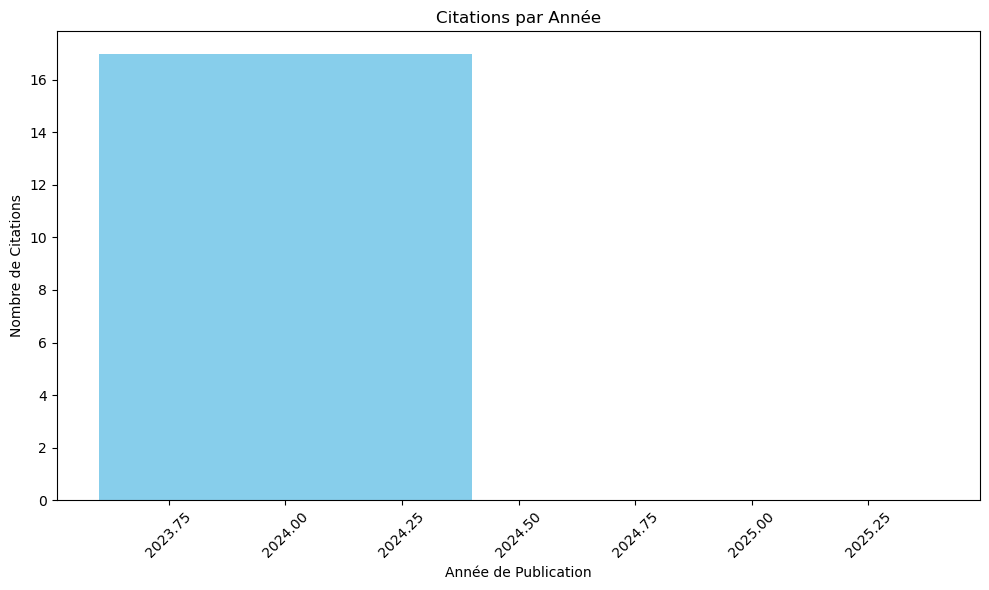

In [98]:
import pandas as pd
import matplotlib.pyplot as plt

# Charger le DataFrame sauvegardé depuis le fichier CSV
df = pd.read_csv('api_scopus_data.csv')

def citations_per_year(df):
    """Analyse les citations par année."""
    if 'citedby-count' in df.columns and 'prism:coverDate' in df.columns:
        # Convertir prism:coverDate en année
        df['coverYear'] = pd.to_datetime(df['prism:coverDate'], errors='coerce').dt.year
        
        citations_by_year = df.groupby('coverYear')['citedby-count'].sum()
        print("\nCitations par année :")
        print(citations_by_year)
        return citations_by_year  # Retourne les citations par année
    else:
        print("Les colonnes nécessaires ('citedby-count' et 'prism:coverDate') ne sont pas présentes dans le DataFrame.")
        return None

# Appel de la fonction pour obtenir les citations par année
citations_by_year = citations_per_year(df)

# Vérification si les données ont été correctement chargées
if citations_by_year is not None:
    # Visualisation des citations par année
    plt.figure(figsize=(10, 6))
    plt.bar(citations_by_year.index, citations_by_year.values, color='skyblue')
    plt.xlabel('Année de Publication')
    plt.ylabel('Nombre de Citations')
    plt.title('Citations par Année')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
else:
    print("Impossible de visualiser les données car les citations par année n'ont pas été calculées correctement.")


## Visualisation de la distribution des citations par publication

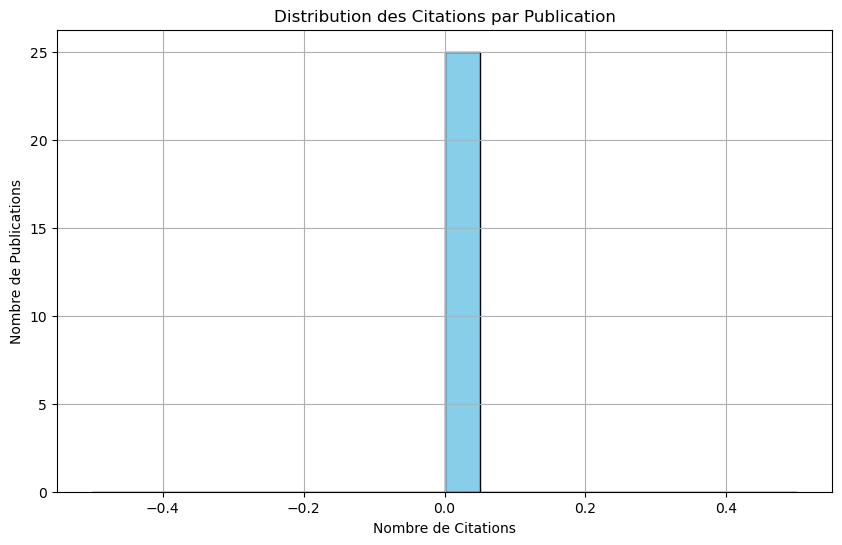

In [15]:
import matplotlib.pyplot as plt

def citations_distribution(df):
    """Visualizes the distribution of citations."""
    if 'citedby-count' in df.columns:
        plt.figure(figsize=(10, 6))
        plt.hist(df['citedby-count'], bins=20, color='skyblue', edgecolor='black')
        plt.title('Distribution des Citations par Publication')
        plt.xlabel('Nombre de Citations')
        plt.ylabel('Nombre de Publications')
        plt.grid(True)
        plt.show()
    else:
        print("La colonne 'citedby-count' n'est pas présente dans le DataFrame.")

# Appel de la fonction
citations_distribution(df)


## Analyse et visualisation de la répartition des publications par auteur


Répartition des publications par auteur :
dc:creator
Daneshvar M.              1
de la Barra Ortiz H.A.    1
De La Cruz-Vargas J.A.    1
Chakraborty S.            1
Peruchini M.              1
Abushamma F.              1
Abd El-Aal N.H.           1
Pranić S.                 1
Kazemi A.                 1
Zheng C.                  1
Name: count, dtype: int64


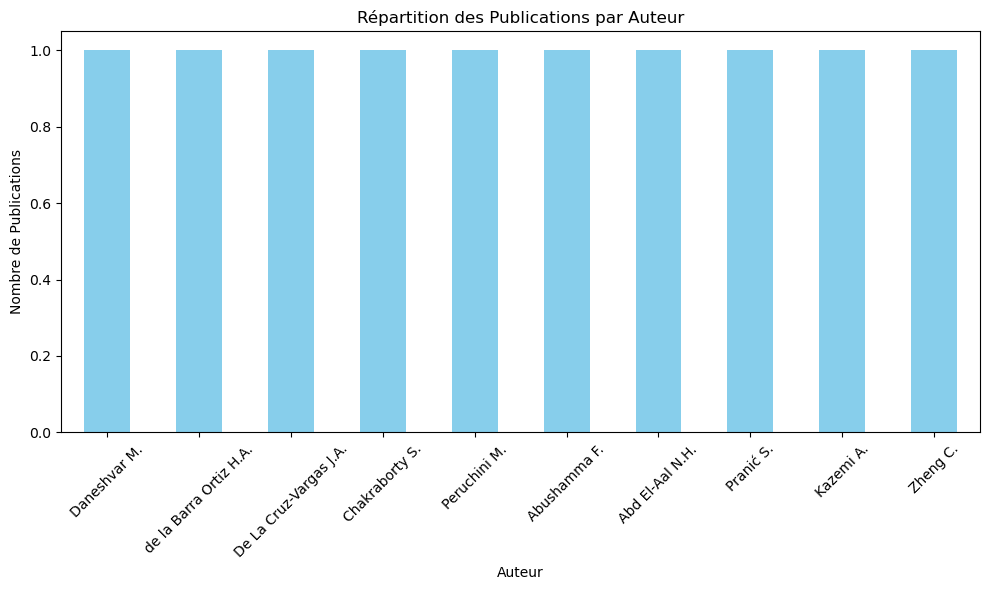

In [33]:
def publications_per_author(df):
    """Analyse la répartition des publications par auteur."""
    if 'dc:creator' in df.columns:
        publications_by_author = df['dc:creator'].value_counts()

        print("\nRépartition des publications par auteur :")
        print(publications_by_author.head(10))  # Afficher les 10 premiers auteurs par nombre de publications

        # Visualisation des publications par auteur (10 premiers auteurs)
        plt.figure(figsize=(10, 6))
        publications_by_author.head(10).plot(kind='bar', color='skyblue')
        plt.xlabel('Auteur')
        plt.ylabel('Nombre de Publications')
        plt.title('Répartition des Publications par Auteur')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
    else:
        print("La colonne 'dc:creator' n'est pas présente dans le DataFrame.")

# Appel de la fonction pour analyser la répartition des publications par auteur
publications_per_author(df)


## Visualisation de la distribution des citations par type de publication

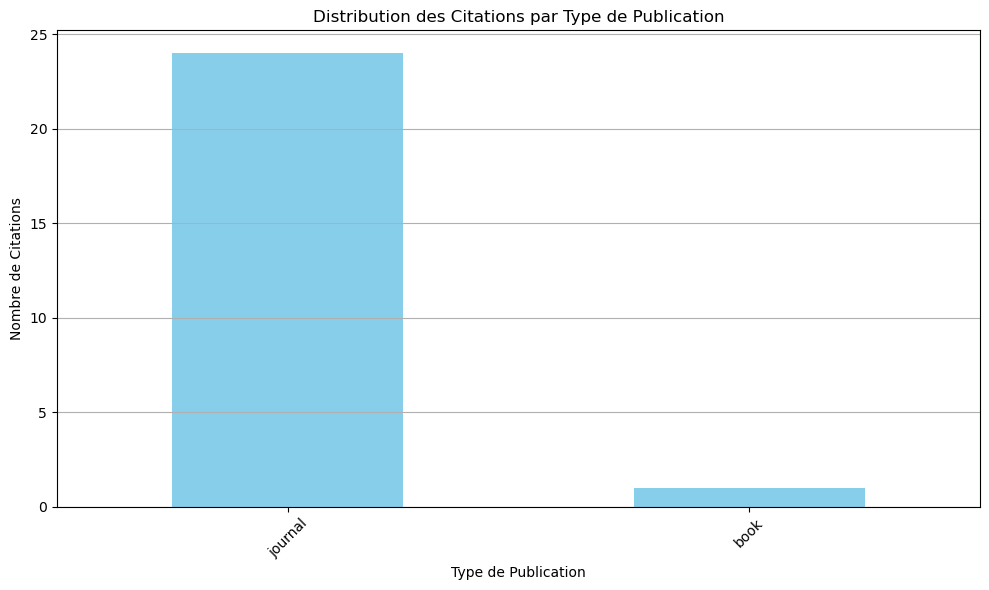

In [100]:
def distribution_citations_par_type(df):
    """Visualise la distribution des citations par type de publication."""
    if 'citedby-count' in df.columns and 'prism:aggregationType' in df.columns:
        plt.figure(figsize=(10, 6))
        df_filtered = df[df['prism:aggregationType'].notna()]
        df_filtered['prism:aggregationType'] = df_filtered['prism:aggregationType'].str.lower()
        df_filtered['prism:aggregationType'].value_counts().plot(kind='bar', color='skyblue')
        plt.xlabel('Type de Publication')
        plt.ylabel('Nombre de Citations')
        plt.title('Distribution des Citations par Type de Publication')
        plt.grid(axis='y')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
    else:
        print("Les colonnes nécessaires ('citedby-count' et 'prism:aggregationType') ne sont pas présentes dans le DataFrame.")

# Appel de la fonction pour visualiser la distribution des citations par type de publication
distribution_citations_par_type(df)


## Visualisation du Nombre de Citations par Publication


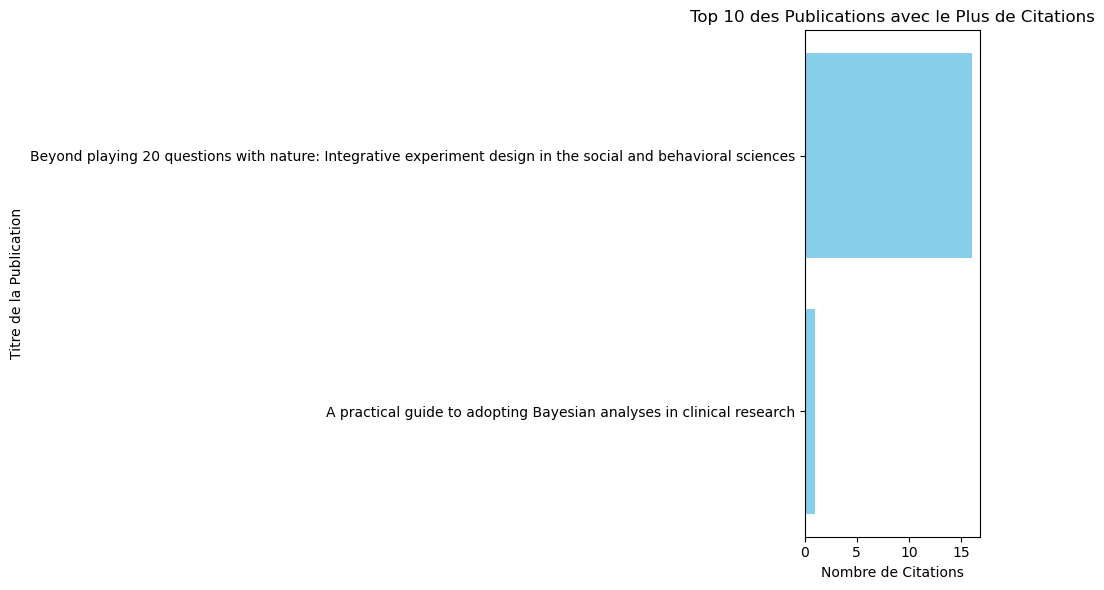

In [109]:
import matplotlib.pyplot as plt

def plot_citations_per_publication(df):
    """Plot the number of citations per publication."""
    if 'citedby-count' in df.columns:
        # Filtrer les publications avec un nombre de citations non nul
        df_filtered = df[df['citedby-count'] > 0]

        # Tri des publications par nombre de citations (top 10)
        top_publications = df_filtered.nlargest(10, 'citedby-count')

        # Création du graphique à barres
        plt.figure(figsize=(10, 6))
        plt.barh(top_publications['dc:title'], top_publications['citedby-count'], color='skyblue')
        plt.xlabel('Nombre de Citations')
        plt.ylabel('Titre de la Publication')
        plt.title('Top 10 des Publications avec le Plus de Citations')
        plt.gca().invert_yaxis()  # Inverser l'ordre des publications pour afficher du plus grand au plus petit
        plt.tight_layout()
        plt.show()
    else:
        print("La colonne 'citedby-count' n'est pas présente dans le DataFrame.")

# Appel de la fonction pour visualiser le nombre de citations par publication
plot_citations_per_publication(df)


## Tendance des Publications au Fil du Temps


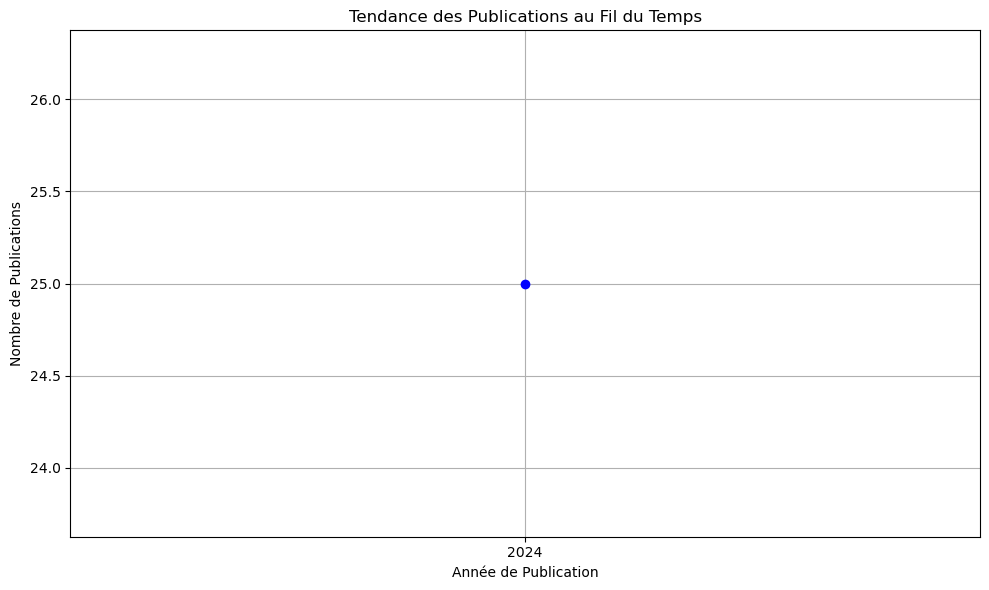

In [51]:
def plot_publications_trend(df):
    """Plot the trend of publications over time."""
    if 'coverYear' in df.columns:
        # Compter le nombre de publications par année
        publications_per_year = df['coverYear'].value_counts().sort_index()

        # Création du graphique linéaire
        plt.figure(figsize=(10, 6))
        plt.plot(publications_per_year.index, publications_per_year.values, marker='o', linestyle='-', color='b')
        plt.xlabel('Année de Publication')
        plt.ylabel('Nombre de Publications')
        plt.title('Tendance des Publications au Fil du Temps')
        plt.grid(True)
        plt.xticks(publications_per_year.index)
        plt.tight_layout()
        plt.show()
    else:
        print("La colonne 'coverYear' n'est pas présente dans le DataFrame.")

# Appel de la fonction pour visualiser la tendance des publications au fil du temps
plot_publications_trend(df)


## Répartition des Publications par Type de Volume


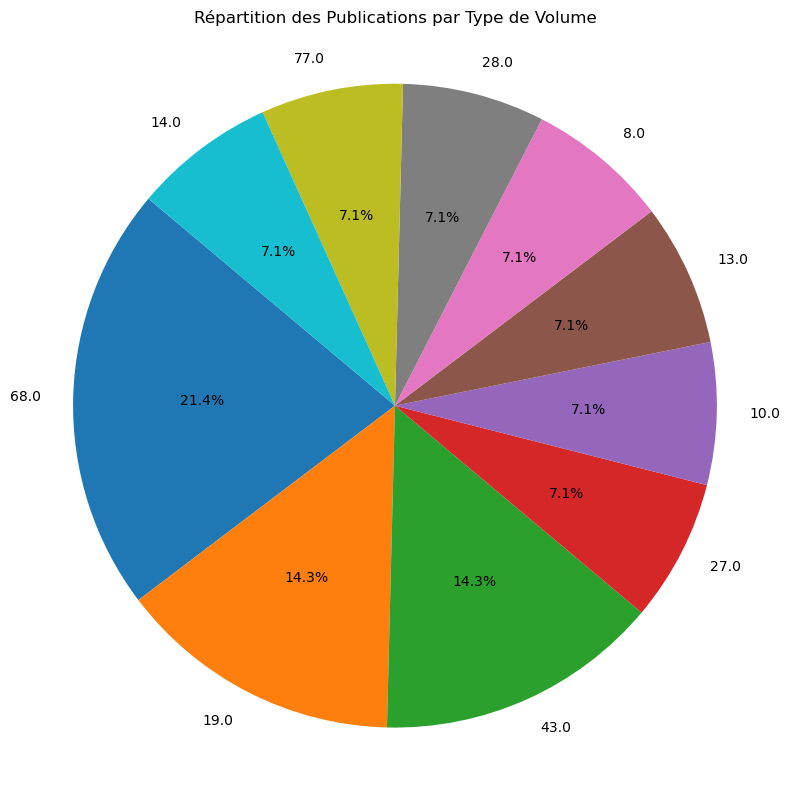

In [110]:
def plot_publications_by_volume(df):
    """Plot the distribution of publications by volume type."""
    if 'prism:volume' in df.columns:
        # Compter le nombre de publications par type de volume (top 10)
        publications_by_volume = df['prism:volume'].value_counts().head(10)

        # Création du graphique à secteurs
        plt.figure(figsize=(8, 8))
        plt.pie(publications_by_volume.values, labels=publications_by_volume.index, autopct='%1.1f%%', startangle=140)
        plt.title('Répartition des Publications par Type de Volume')
        plt.axis('equal')
        plt.tight_layout()
        plt.show()
    else:
        print("La colonne 'prism:volume' n'est pas présente dans le DataFrame.")

# Appel de la fonction pour visualiser la répartition des publications par type de volume
plot_publications_by_volume(df)


## Répartition des Publications par Auteur (Top 10)


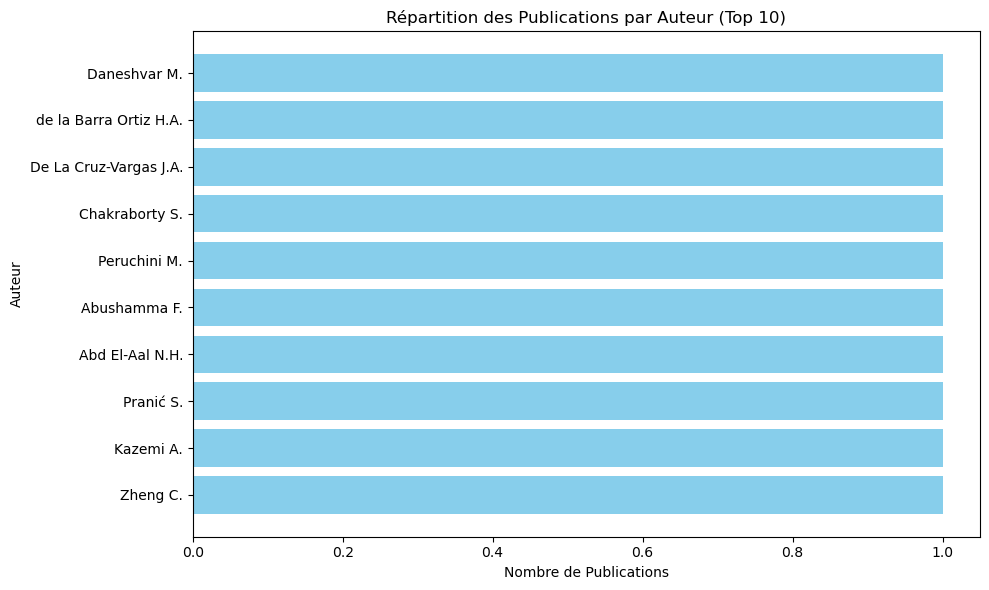

In [53]:
def plot_publications_by_author(df):
    """Plot the distribution of publications by author."""
    if 'dc:creator' in df.columns:
        # Compter le nombre de publications par auteur (top 10)
        publications_by_author = df['dc:creator'].value_counts().head(10)

        # Création du graphique à barres horizontales
        plt.figure(figsize=(10, 6))
        plt.barh(publications_by_author.index, publications_by_author.values, color='skyblue')
        plt.xlabel('Nombre de Publications')
        plt.ylabel('Auteur')
        plt.title('Répartition des Publications par Auteur (Top 10)')
        plt.gca().invert_yaxis()  # Inverser l'ordre des auteurs pour afficher du plus grand au plus petit
        plt.tight_layout()
        plt.show()
    else:
        print("La colonne 'dc:creator' n'est pas présente dans le DataFrame.")

# Appel de la fonction pour visualiser la répartition des publications par auteur
plot_publications_by_author(df)


## Répartition des Publications par Source


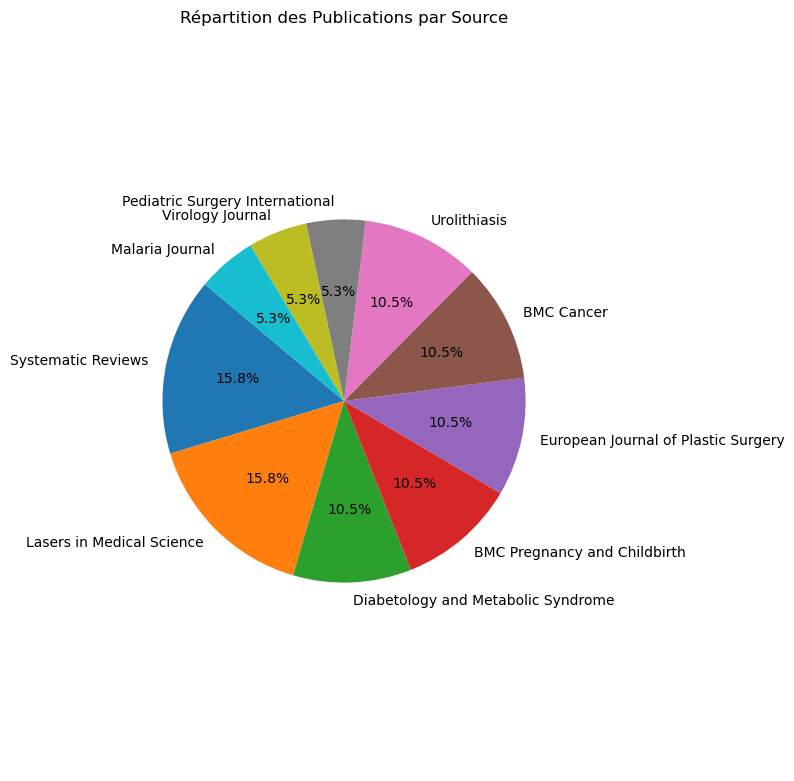

In [54]:
def plot_publications_by_source(df):
    """Plot the distribution of publications by source."""
    if 'prism:publicationName' in df.columns:
        # Compter le nombre de publications par source (top 10)
        publications_by_source = df['prism:publicationName'].value_counts().head(10)

        # Création du graphique à secteurs
        plt.figure(figsize=(8, 8))
        plt.pie(publications_by_source.values, labels=publications_by_source.index, autopct='%1.1f%%', startangle=140)
        plt.title('Répartition des Publications par Source')
        plt.axis('equal')
        plt.tight_layout()
        plt.show()
    else:
        print("La colonne 'prism:publicationName' n'est pas présente dans le DataFrame.")

# Appel de la fonction pour visualiser la répartition des publications par source
plot_publications_by_source(df)


## Distribution des Citations par Publication


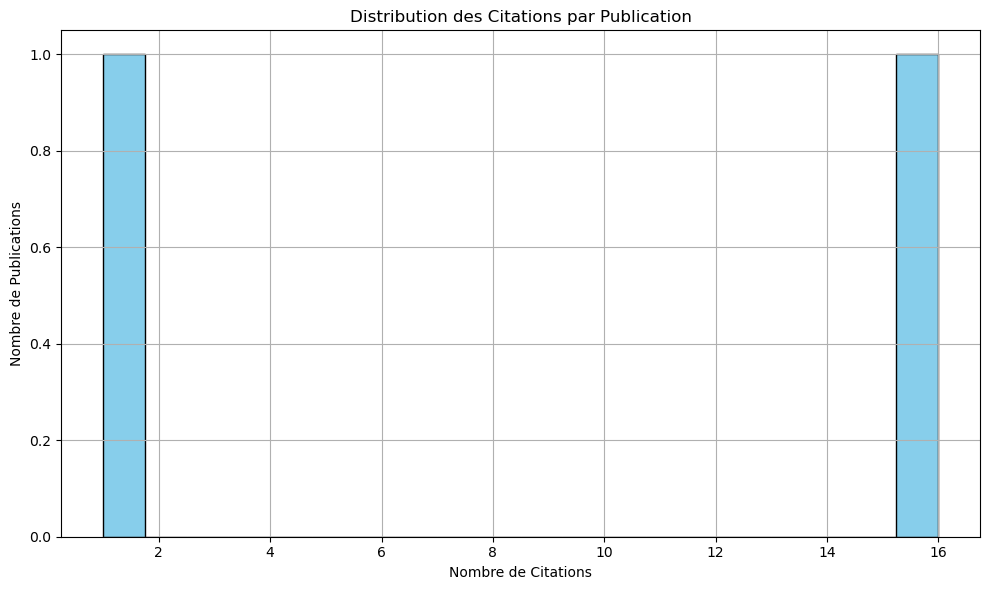

In [111]:
def plot_citations_distribution(df):
    """Plot the distribution of citations per publication."""
    if 'citedby-count' in df.columns:
        # Filtrer les publications avec un nombre de citations non nul
        df_filtered = df[df['citedby-count'] > 0]

        # Création de l'histogramme des citations
        plt.figure(figsize=(10, 6))
        plt.hist(df_filtered['citedby-count'], bins=20, color='skyblue', edgecolor='black')
        plt.xlabel('Nombre de Citations')
        plt.ylabel('Nombre de Publications')
        plt.title('Distribution des Citations par Publication')
        plt.grid(True)
        plt.tight_layout()
        plt.show()
    else:
        print("La colonne 'citedby-count' n'est pas présente dans le DataFrame.")

# Appel de la fonction pour visualiser la distribution des citations par publication
plot_citations_distribution(df)


### Installation de la bibliothèque rdflib avec Python


In [62]:
 !pip install rdflib


Defaulting to user installation because normal site-packages is not writeable


DEPRECATION: Loading egg at c:\programdata\anaconda3\lib\site-packages\vboxapi-1.0-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330


### Import des Bibliothèques RDFLib et Requests


In [219]:
import requests
import pandas as pd
from rdflib import Graph, Literal, RDF, URIRef, Namespace
from rdflib.namespace import DC


### Fonction pour Récupérer les Données depuis l'API Scopus


In [220]:
def fetch_scopus_data(api_key, query, count=25):
    """Fetch data from the Scopus API."""
    url = 'https://api.elsevier.com/content/search/scopus'
    params = {
        'apiKey': api_key,
        'query': query,
        'count': count
    }

    try:
        response = requests.get(url, params=params)
        response.raise_for_status()
        data = response.json()

        if 'search-results' in data and 'entry' in data['search-results']:
            return data['search-results']['entry']
        else:
            print("La structure de la réponse JSON ne contient pas les clés attendues.")
            return None
    except requests.exceptions.HTTPError as http_err:
        print(f'Erreur HTTP {response.status_code}: {response.reason}')
        print(response.text)
    except requests.exceptions.RequestException as req_err:
        print(f'Erreur de requête: {req_err}')
    except Exception as err:
        print(f'Erreur: {err}')


### Fonction pour Parser les Valeurs FreetoRead


In [221]:
def parse_freetoread(value):
    if isinstance(value, list):
        return ', '.join([item['$'] for item in value])
    return value


### Fonction pour Nettoyer et Sauvegarder les Données


In [222]:
def clean_and_save_data(entries, filename):
    if entries:
        df = pd.json_normalize(entries)

        if 'freetoread.value' in df.columns:
            df['freetoread.value'] = df['freetoread.value'].apply(parse_freetoread)

        pd.set_option('display.max_rows', None)
        pd.set_option('display.max_columns', None)
        pd.set_option('display.width', None)
        pd.set_option('display.max_colwidth', None)

        #print(df)

        df.to_csv(filename, index=False)
        print(f"Les données ont été nettoyées et sauvegardées dans le fichier {filename}")


### Fonction pour Créer un RDF à partir d'un CSV


In [223]:
from rdflib import Graph, Namespace, Literal, URIRef
from rdflib.namespace import RDF, DC
import pandas as pd

def create_rdf_from_csv(csv_file, rdf_file):
    df = pd.read_csv(csv_file)
    g = Graph()

    SCOPUS = Namespace('http://example.org/scopus/')
    g.bind('scopus', SCOPUS)
    g.bind('dc', DC)

    for index, row in df.iterrows():
        publication = URIRef(f"http://example.org/scopus/publication/{index}")
        g.add((publication, RDF.type, SCOPUS.Publication))

        if 'dc:title' in row and pd.notna(row['dc:title']):
            g.add((publication, DC.title, Literal(row['dc:title'])))

        if 'citedby-count' in row and pd.notna(row['citedby-count']):
            g.add((publication, SCOPUS.citedbyCount, Literal(row['citedby-count'])))
            
        if 'prism:publicationName' in row and pd.notna(row['prism:publicationName']):
            g.add((publication, SCOPUS.publicationName, Literal(row['prism:publicationName'])))

        if 'dc:creator' in row and pd.notna(row['dc:creator']):
            g.add((publication, DC.creator, Literal(row['dc:creator'])))

        if 'prism:coverDate' in row and pd.notna(row['prism:coverDate']):
            g.add((publication, DC.date, Literal(row['prism:coverDate'])))

        if 'freetoread.value' in row and pd.notna(row['freetoread.value']):
            g.add((publication, SCOPUS.freetoRead, Literal(row['freetoread.value'])))

        # Ajout des autres colonnes spécifiées
        if 'prism:eIssn' in row and pd.notna(row['prism:eIssn']):
            g.add((publication, SCOPUS.eIssn, Literal(row['prism:eIssn'])))

        if 'prism:volume' in row and pd.notna(row['prism:volume']):
            g.add((publication, SCOPUS.volume, Literal(row['prism:volume'])))

        if 'prism:issueIdentifier' in row and pd.notna(row['prism:issueIdentifier']):
            g.add((publication, SCOPUS.issueIdentifier, Literal(row['prism:issueIdentifier'])))

        if 'prism:pageRange' in row and pd.notna(row['prism:pageRange']):
            g.add((publication, SCOPUS.pageRange, Literal(row['prism:pageRange'])))

        if 'prism:coverDisplayDate' in row and pd.notna(row['prism:coverDisplayDate']):
            g.add((publication, SCOPUS.coverDisplayDate, Literal(row['prism:coverDisplayDate'])))

        if 'prism:doi' in row and pd.notna(row['prism:doi']):
            g.add((publication, SCOPUS.doi, Literal(row['prism:doi'])))

        if 'affiliation' in row and pd.notna(row['affiliation']):
            g.add((publication, SCOPUS.affiliation, Literal(row['affiliation'])))

        if 'prism:aggregationType' in row and pd.notna(row['prism:aggregationType']):
            g.add((publication, SCOPUS.aggregationType, Literal(row['prism:aggregationType'])))

        if 'subtype' in row and pd.notna(row['subtype']):
            g.add((publication, SCOPUS.subtype, Literal(row['subtype'])))

        if 'subtypeDescription' in row and pd.notna(row['subtypeDescription']):
            g.add((publication, SCOPUS.subtypeDescription, Literal(row['subtypeDescription'])))

        if 'article-number' in row and pd.notna(row['article-number']):
            g.add((publication, SCOPUS.articleNumber, Literal(row['article-number'])))

        if 'source-id' in row and pd.notna(row['source-id']):
            g.add((publication, SCOPUS.sourceId, Literal(row['source-id'])))

        if 'openaccess' in row and pd.notna(row['openaccess']):
            g.add((publication, SCOPUS.openAccess, Literal(row['openaccess'])))

        if 'openaccessFlag' in row and pd.notna(row['openaccessFlag']):
            g.add((publication, SCOPUS.openAccessFlag, Literal(row['openaccessFlag'])))

        if 'freetoread.value' in row and pd.notna(row['freetoread.value']):
            g.add((publication, SCOPUS.freetoRead, Literal(row['freetoread.value'])))

        if 'freetoreadLabel.value' in row and pd.notna(row['freetoreadLabel.value']):
            g.add((publication, SCOPUS.freetoReadLabel, Literal(row['freetoreadLabel.value'])))

        if 'prism:issn' in row and pd.notna(row['prism:issn']):
            g.add((publication, SCOPUS.issn, Literal(row['prism:issn'])))

        if 'pubmed-id' in row and pd.notna(row['pubmed-id']):
            g.add((publication, SCOPUS.pubmedId, Literal(row['pubmed-id'])))

        if 'coverYear' in row and pd.notna(row['coverYear']):
            g.add((publication, SCOPUS.coverYear, Literal(row['coverYear'])))

    g.serialize(rdf_file, format='turtle')


### Utilisation de l'API Scopus, Nettoyage des Données, Création d'un RDF et Requête SPARQL


In [224]:

api_key = '9aebde1fa88b0b7325c7d8054dd3e754'
query = 'KEY(scopus)'
filename = 'api_scopus_data.csv'
rdf_filename = 'scopus_data.ttl'

# Récupération et nettoyage des données
entries = fetch_scopus_data(api_key, query)
clean_and_save_data(entries, filename)

# Création du fichier RDF à partir du CSV
create_rdf_from_csv(filename, rdf_filename)
print(f"Les données RDF ont été créées à partir du fichier {filename}.")

def execute_sparql_query_and_style_results(rdf_filename, sparql_query):
    g = Graph()
    g.parse(rdf_filename, format='turtle')

    # Execute the SPARQL query
    results = g.query(sparql_query)

    # Styling the results
    print("Les noms de publication et dates :\n")
    for idx, row in enumerate(results):
        publication_name = row['publicationName']
        cover_date = row['coverDate']

        # Print each result with styling
        print(f"{idx + 1}. Publication Name: {publication_name}")
        print(f"   Date: {cover_date}\n")


sparql_query_publications_info = """
PREFIX scopus: <http://example.org/scopus/>
PREFIX dc: <http://purl.org/dc/elements/1.1/>
PREFIX prism: <http://prismstandard.org/namespaces/basic/2.0/>

SELECT ?publicationName ?coverDate
WHERE {
    ?publication a scopus:Publication ;
                dc:date ?coverDate ;
                scopus:publicationName ?publicationName .
}
LIMIT 5
"""
execute_sparql_query_and_style_results(rdf_filename, sparql_query_publications_info)


Les données ont été nettoyées et sauvegardées dans le fichier api_scopus_data.csv
Les données RDF ont été créées à partir du fichier api_scopus_data.csv.
Les noms de publication et dates :

1. Publication Name: Systematic Reviews
   Date: 2024-12-01

2. Publication Name: BMC Psychiatry
   Date: 2024-12-01

3. Publication Name: BMC Pregnancy and Childbirth
   Date: 2024-12-01

4. Publication Name: Thrombosis Journal
   Date: 2024-12-01

5. Publication Name: Diabetology and Metabolic Syndrome
   Date: 2024-12-01



In [212]:
def execute_sparql_query_authors_and_titles(rdf_filename, sparql_query):
    g = Graph()
    g.parse(rdf_filename, format='turtle')

    # Execute the SPARQL query
    results = g.query(sparql_query)

    # Store results in a list of tuples
    data = [(row['creator'], row['title']) for row in results]

    return data

# Votre requête SPARQL
sparql_query_authors_and_titles = """
PREFIX scopus: <http://example.org/scopus/>
PREFIX dc: <http://purl.org/dc/elements/1.1/>

SELECT ?creator ?title
WHERE {
    ?publication a scopus:Publication .
    ?publication dc:creator ?creator .
    ?publication dc:title ?title .
}
LIMIT 5
"""

# Appel de la fonction pour exécuter la requête et obtenir les résultats sous forme de liste de tuples
results = execute_sparql_query_authors_and_titles(rdf_filename, sparql_query_authors_and_titles)

# Affichage des résultats sous forme de liste de tuples
print("\nCréateurs et titres des publications :")
for creator, title in results:
    print(f"Auteur: {creator}\nTitre: {title}\n")



Créateurs et titres des publications :
Auteur: Benavides-Gil G.
Titre: Mindfulness-based interventions for improving mental health of frontline healthcare professionals during the COVID-19 pandemic: a systematic review

Auteur: Bafkar N.
Titre: Efficacy and safety of omega-3 fatty acids supplementation for anxiety symptoms: a systematic review and dose-response meta-analysis of randomized controlled trials

Auteur: Moradkhani A.
Titre: Association of vitamin D receptor genetic polymorphisms with the risk of infertility: a systematic review and meta-analysis

Auteur: Maghsudlu M.
Titre: Systematic review and meta-analysis of association between plasminogen activator inhibitor-1 4G/5G polymorphism and recurrent pregnancy loss: an update

Auteur: Miao Z.
Titre: Impact of frailty on mortality, hospitalization, cardiovascular events, and complications in patients with diabetes mellitus: a systematic review and meta-analysis



In [225]:
def execute_sparql_query_publications_by_year(rdf_file, sparql_query):
    # Fonction pour exécuter la requête SPARQL et afficher les résultats
    g = Graph()
    g.parse(rdf_file, format='turtle')

    qres = g.query(sparql_query)
    
    # Affichage des résultats sous forme de tableau
    print("\nNombre de publications par année :")
    print("{:<10} {:<10}".format("Year", "Count"))
    print("="*25)
    for row in qres:
        print("{:<10} {:<10}".format(row['year'], row['count']))

sparql_query_publications_by_year = """
PREFIX scopus: <http://example.org/scopus/>
PREFIX dc: <http://purl.org/dc/elements/1.1/>
PREFIX prism: <http://prismstandard.org/namespaces/basic/2.0/>

SELECT ((?coverDate) AS ?year) (COUNT(?publication) AS ?count)
WHERE {
    ?publication a scopus:Publication ;
                dc:date ?coverDate .
}
GROUP BY ?year
"""
# Appel de la fonction avec la nouvelle requête et le nom de fonction modifié
execute_sparql_query_publications_by_year(rdf_filename, sparql_query_publications_by_year)



Nombre de publications par année :
Year       Count     
2024-12-01 25        


In [226]:
def execute_sparql_query_doi_and_publication_name(rdf_file, sparql_query):
    # Fonction pour exécuter la requête SPARQL et afficher les résultats
    g = Graph()
    g.parse(rdf_file, format='turtle')

    qres = g.query(sparql_query)
    
    # Affichage des résultats sous forme de tableau
    print("\nAffichage des DOI et noms de publication :")
    print("{:<30} {:<70}".format("DOI", "Publication Name"))
    print("="*100)
    for row in qres:
        print("{:<30} {:<70}".format(row['doi'], row['publicationName']))

sparql_query_doi_and_publication_name = """
PREFIX scopus: <http://example.org/scopus/>
PREFIX dc: <http://purl.org/dc/elements/1.1/>
PREFIX prism: <http://prismstandard.org/namespaces/basic/2.0/>

SELECT ?doi ?publicationName
WHERE {
    ?publication a scopus:Publication ;
                scopus:doi ?doi ;
                scopus:publicationName ?publicationName .
}
LIMIT 6
"""
# Appel de la fonction avec la nouvelle requête et le nom de fonction modifié
execute_sparql_query_doi_and_publication_name(rdf_filename, sparql_query_doi_and_publication_name)



Affichage des DOI et noms de publication :
DOI                            Publication Name                                                      
10.1186/s13643-024-02574-5     Systematic Reviews                                                    
10.1186/s12888-024-05881-2     BMC Psychiatry                                                        
10.1186/s12884-024-06590-0     BMC Pregnancy and Childbirth                                          
10.1186/s12959-024-00612-9     Thrombosis Journal                                                    
10.1186/s13098-024-01352-6     Diabetology and Metabolic Syndrome                                    
10.1007/s00238-024-02190-5     European Journal of Plastic Surgery                                   


In [227]:
def execute_sparql_query_volume(rdf_file, sparql_query):
    # Fonction pour exécuter la requête SPARQL et afficher les résultats
    g = Graph()
    g.parse(rdf_file, format='turtle')

    qres = g.query(sparql_query)
    
    # Affichage des résultats sous forme de tableau
    print("\nAffichage des volumes des publications :")
    print("{:<10} {:<30}".format("Publication", "Volume"))
    print("="*50)
    for row in qres:
        print("{:<10} {:<30}".format(row['publication'], row['volume']))

sparql_query_volume = """
PREFIX scopus: <http://example.org/scopus/>
PREFIX prism: <http://prismstandard.org/namespaces/basic/2.0/>

SELECT ?publication ?volume
WHERE {
    ?publication a scopus:Publication ;
                scopus:volume ?volume .
}
LIMIT 10
"""
# Appel de la fonction avec la requête pour les volumes des publications
execute_sparql_query_volume(rdf_filename, sparql_query_volume)



Affichage des volumes des publications :
Publication Volume                        
http://example.org/scopus/publication/0 13                            
http://example.org/scopus/publication/1 24                            
http://example.org/scopus/publication/10 24                            
http://example.org/scopus/publication/11 22                            
http://example.org/scopus/publication/12 16                            
http://example.org/scopus/publication/13 47                            
http://example.org/scopus/publication/14 24                            
http://example.org/scopus/publication/15 13                            
http://example.org/scopus/publication/16 24                            
http://example.org/scopus/publication/17 39                            


In [228]:
from rdflib import Graph, Namespace

def execute_sparql_query_article_volume(rdf_file, sparql_query):
    # Chargement du fichier RDF
    g = Graph()
    g.parse(rdf_file, format='turtle')

    # Exécution de la requête SPARQL
    qres = g.query(sparql_query)

    # Affichage des résultats
    print("\nPublications de type 'Article' avec leur volume :")
    print("=" * 50)
    for row in qres:
        print(f"Titre de la publication : {row['title']}")
        print(f"Volume : {row['volume']}")
        print("-" * 50)

# Requête SPARQL pour récupérer les articles avec leur volume
sparql_query_article_volume = """
PREFIX scopus: <http://example.org/scopus/>
PREFIX prism: <http://prismstandard.org/namespaces/basic/2.0/>

SELECT ?title (GROUP_CONCAT(?volume; separator=", ") AS ?volume)
WHERE {
    ?publication a scopus:Publication ;
                scopus:subtypeDescription "Article" ;
                scopus:volume ?volume ;
                dc:title ?title .
}
GROUP BY ?title
LIMIT 10
"""

# Appel de la fonction avec la requête pour les articles et leur volume
execute_sparql_query_article_volume(rdf_filename, sparql_query_article_volume)



Publications de type 'Article' avec leur volume :
Titre de la publication : Mindfulness-based interventions for improving mental health of frontline healthcare professionals during the COVID-19 pandemic: a systematic review
Volume : 13
--------------------------------------------------
Titre de la publication : Efficacy and safety of omega-3 fatty acids supplementation for anxiety symptoms: a systematic review and dose-response meta-analysis of randomized controlled trials
Volume : 24
--------------------------------------------------
Titre de la publication : Association of vitamin D receptor genetic polymorphisms with the risk of infertility: a systematic review and meta-analysis
Volume : 24
--------------------------------------------------
Titre de la publication : Impact of frailty on mortality, hospitalization, cardiovascular events, and complications in patients with diabetes mellitus: a systematic review and meta-analysis
Volume : 16
-------------------------------------------